In [1]:
import joblib
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import numpy as np
from pytorch_tabnet.tab_model import TabNetRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

# Verifica si CUDA está disponible
cuda_available = torch.cuda.is_available()
print(f"CUDA disponible: {cuda_available}")

# En caso de estar disponible, verifica cuántos dispositivos CUDA están disponibles
if cuda_available:
    print(f"Dispositivos CUDA disponibles: {torch.cuda.device_count()}")
    print(f"Nombre del dispositivo: {torch.cuda.get_device_name(0)}")

# Se define el dispositivo a utilizar
device = "cuda" if cuda_available else "cpu"



CUDA disponible: True
Dispositivos CUDA disponibles: 1
Nombre del dispositivo: NVIDIA GeForce RTX 3090


In [2]:
#Se a cargar el dataset test_set_P1-ALL full.cxv
test_set = pd.read_csv('test_set_P1-ALL full_predicciones.csv')

In [3]:
# Crear una nueva columna con el ratio de asistencia calculado por cada día de la semana
asistencia_por_dia = test_set.groupby('App_DayOfWeek')['Valor_real_inasistencia'].mean().reset_index()

# Renombrar la columna que contiene el valor medio de inasistencia a 'Ratio_asistencia'
asistencia_por_dia.rename(columns={'Valor_real_inasistencia': 'Absence_ratio_DayOfWeek'}, inplace=True)

# Ahora unimos este ratio de asistencia al DataFrame original usando la columna 'App_DayOfWeek' como llave
test_set = test_set.merge(asistencia_por_dia, on='App_DayOfWeek', how='left')

In [4]:
# Número de pacientes únicos
NUMBER_PATIENTS = test_set['PatientId'].nunique()
print('Variable NUMBER_PATIENTS: ', NUMBER_PATIENTS)

# Distribución de NoShow igual a 1
class_counts = test_set['NoShow'].value_counts()
NUMBER_NO_SHOWS = class_counts[1]
print('Variable NUMBER_NO_SHOWS: ', NUMBER_NO_SHOWS)

# Numero de filas
NUMBER_SAMPLES = test_set.shape[0]
print('Variable NUMBER_SAMPLES: ', NUMBER_SAMPLES)

Variable NUMBER_PATIENTS:  22097
Variable NUMBER_NO_SHOWS:  4461
Variable NUMBER_SAMPLES:  22097


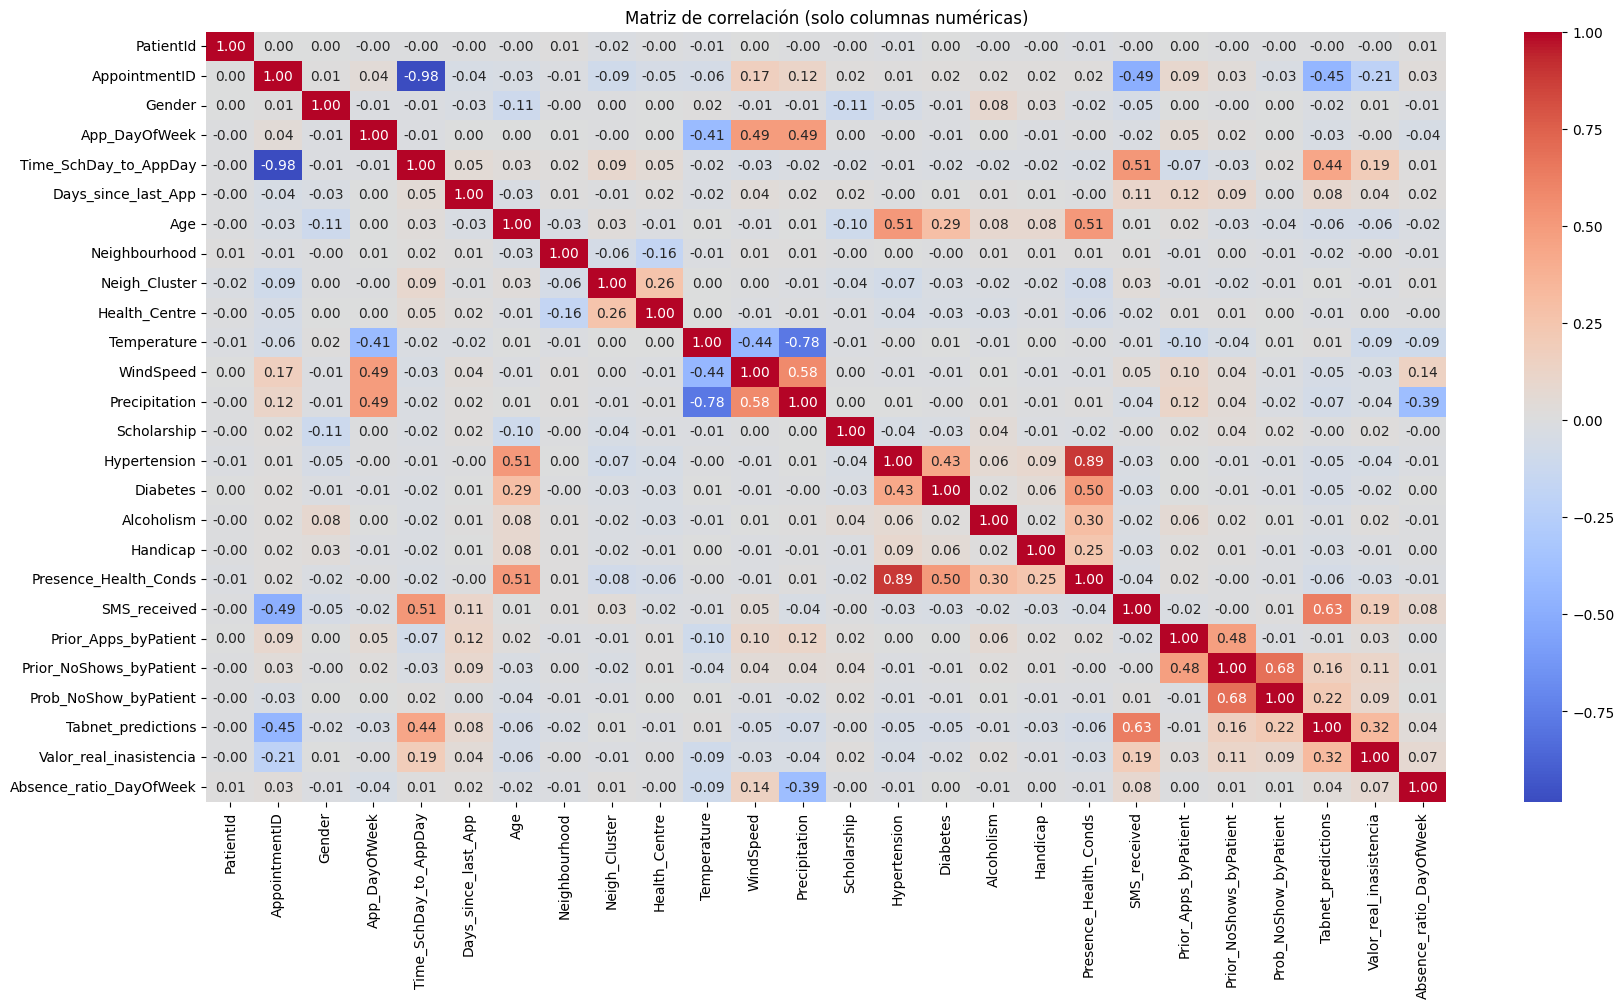

In [5]:
# Seleccionar solo las columnas numéricas para el cálculo de la matriz de correlación
numeric_columns = test_set.select_dtypes(include=['float64', 'int64'])

# Cálculo de la matriz de correlación usando solo columnas numéricas
correlation = numeric_columns.corr()

# Visualización de la matriz de correlación con un mapa de calor
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación (solo columnas numéricas)")
plt.show()


In [6]:
NUMBER_Apps_inTest = int(NUMBER_SAMPLES * 0.20)
print(f"Para alcanzar el 20% del muestreo en nuestro set de pruebas\n \
necesitamos {NUMBER_Apps_inTest} citas de pacientes distintos, es decir,\n \
muestras de un {NUMBER_Apps_inTest / NUMBER_PATIENTS:.2%} de los pacientes.")

Para alcanzar el 20% del muestreo en nuestro set de pruebas
 necesitamos 4419 citas de pacientes distintos, es decir,
 muestras de un 20.00% de los pacientes.


In [7]:
# Creación del sub-dataset que contiene sólo la última cita de cada paciente
last_app_byPatient = test_set.groupby('PatientId').last().reset_index()

# Ordenación por 'AppointmentDay'
last_app_byPatient = last_app_byPatient.sort_values(by='AppointmentDay')

# Cálculo del número de citas NoShow = True que se requieren para mantener la estratificación de Clases
NUMBER_NoShows_inTest = int(NUMBER_Apps_inTest * (NUMBER_NO_SHOWS / NUMBER_SAMPLES))
NUMBER_Shows_inTest = int(NUMBER_Apps_inTest - NUMBER_NoShows_inTest)
print(f"Se requieren {NUMBER_NoShows_inTest} pacientes con 'NoShow' = True en el Set de Prueba, y\n \
{NUMBER_Shows_inTest} pacientes con 'NoShow' = False.\n")

# Selección de las últimas muestras del sub-dataset 'last_app_byPatient' con 'NoShow' = True
test_set_NoShows = last_app_byPatient[last_app_byPatient['NoShow'] == True].iloc[-NUMBER_NoShows_inTest:]

# Selección de las últimas muestras del sub-dataset 'last_app_byPatient' con 'NoShow' = False
test_set_Shows = last_app_byPatient[last_app_byPatient['NoShow'] == False].iloc[-NUMBER_Shows_inTest:]

# Concatenación de ambos sub-dataset en el Set de Pruebas
test_set = pd.concat([test_set_NoShows, test_set_Shows])

# Crear índices de forma aleatoria sin usar numpy
test_size = 0.2  # Proporción de datos para el set de pruebas
test_indices = random.sample(list(test_set.index), int(test_size * len(test_set)))
train_indices = test_set.index.difference(test_indices)

# Selección del Set de Pruebas definitivo
test_set_v2 = test_set.loc[test_indices]
print(f"Creado Set de Prueba con {test_set_v2.shape[0]} citas de \
{test_set_v2['PatientId'].nunique()} pacientes distintos.")

# Selección del Set de Entrenamiento definitivo
train_set_v2 = test_set.loc[train_indices]
print(f"Creado Set de Entrenamiento con {train_set_v2.shape[0]} citas de \
{train_set_v2['PatientId'].nunique()} pacientes distintos.")

Se requieren 892 pacientes con 'NoShow' = True en el Set de Prueba, y
 3527 pacientes con 'NoShow' = False.

Creado Set de Prueba con 883 citas de 883 pacientes distintos.
Creado Set de Entrenamiento con 3536 citas de 3536 pacientes distintos.


In [8]:
# Definición de las variables que no aportan información:
columns_to_drop = ['AppointmentID',
                   'PatientId',
                    'ScheduledDay',
                    'AppointmentDay',
                    'Neighbourhood',
                    'SMS_received']

# En el set de entrenamiento:
train_set_v2.drop(columns = columns_to_drop, inplace = True)
# En el set de pruebas:
test_set_v2.drop(columns = columns_to_drop, inplace = True)

In [9]:
# Convertimos las columnas booleanas a float32
test_set_v2['NoShow'] = test_set_v2['NoShow'].astype('float32')

# Convertimos las columnas int64 a float32
int_columns = test_set_v2.select_dtypes(include=['int64']).columns
test_set_v2[int_columns] = test_set_v2[int_columns].astype('float32')

# Convertimos las columnas float64 a float32
float_columns = test_set_v2.select_dtypes(include=['float64']).columns
test_set_v2[float_columns] = test_set_v2[float_columns].astype('float32')

# Verificamos que todas las columnas ahora son float32
print(test_set_v2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 883 entries, 14310 to 11524
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   883 non-null    float32
 1   App_DayOfWeek            883 non-null    float32
 2   Time_SchDay_to_AppDay    883 non-null    float32
 3   Days_since_last_App      883 non-null    float32
 4   Age                      883 non-null    float32
 5   Neigh_Cluster            883 non-null    float32
 6   Health_Centre            883 non-null    float32
 7   Temperature              883 non-null    float32
 8   WindSpeed                883 non-null    float32
 9   Precipitation            883 non-null    float32
 10  Scholarship              883 non-null    float32
 11  Hypertension             883 non-null    float32
 12  Diabetes                 883 non-null    float32
 13  Alcoholism               883 non-null    float32
 14  Handicap                 

In [10]:
# Se divide el conjunto de entrenamiento en características y etiquetas
X_train_set = train_set_v2.drop('Absence_ratio_DayOfWeek', axis=1)
y_train_set = train_set_v2['Absence_ratio_DayOfWeek']
X_test_set = test_set_v2.drop('Absence_ratio_DayOfWeek', axis=1)
y_test_set = test_set_v2['Absence_ratio_DayOfWeek']

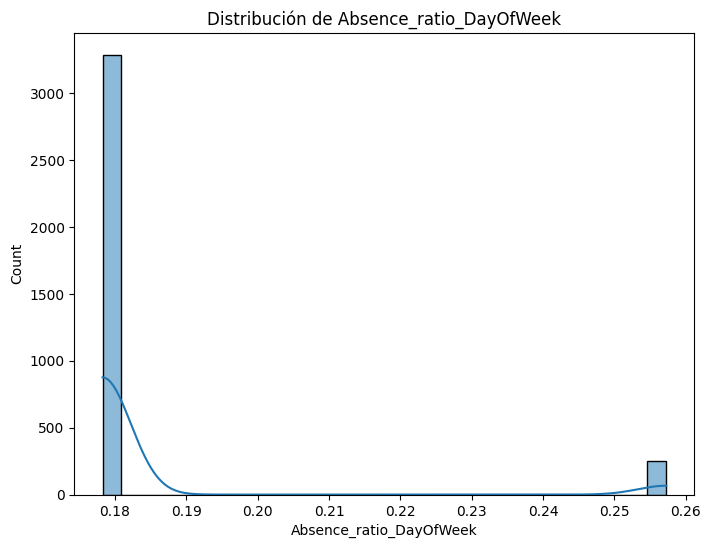

In [11]:
# Visualizamos la distribución de la variable objetivo
plt.figure(figsize=(8, 6))
sns.histplot(y_train_set, bins=30, kde=True)
plt.title('Distribución de Absence_ratio_DayOfWeek')
plt.show()

In [12]:
# Asegúrate de que y_train y y_test sean convertidos a numpy antes de aplicar reshape
y_train_set = y_train_set.to_numpy().astype('float32').reshape(-1, 1)
y_test_set = y_test_set.to_numpy().astype('float32').reshape(-1, 1)

# Asegúrate de que X_train y X_test sean de tipo float32
X_train_set = X_train_set.astype('float32')
X_test_set = X_test_set.astype('float32')

# Verificación
print(f"Tipos de y_train_set: {y_train_set.dtype}")
print(f"Tipos de X_train_set: {X_train_set.dtypes}")
print(f"Tipos de y_test_set: {y_test_set.dtype}")
print(f"Tipos de X_test_set: {X_test_set.dtypes}")

# Si y_train_set y y_test_set son pandas Series, conviértelos a numpy y asegúrate de que sean float32
if isinstance(y_train_set, pd.Series):
    y_train_set = y_train_set.astype('float32').to_numpy().reshape(-1, 1)

if isinstance(y_test_set, pd.Series):
    y_test_set = y_test_set.astype('float32').to_numpy().reshape(-1, 1)

# Si ya son numpy arrays, no es necesario convertirlos de nuevo
if isinstance(y_train_set, np.ndarray):
    y_train_set = y_train_set.astype('float32').reshape(-1, 1)

if isinstance(y_test_set, np.ndarray):
    y_test_set = y_test_set.astype('float32').reshape(-1, 1)

# Asegúrate de que X_train y X_test sean de tipo float32
X_train_set = X_train_set.astype('float32')
X_test_set = X_test_set.astype('float32')


Tipos de y_train_set: float32
Tipos de X_train_set: Gender                     float32
App_DayOfWeek              float32
Time_SchDay_to_AppDay      float32
Days_since_last_App        float32
Age                        float32
Neigh_Cluster              float32
Health_Centre              float32
Temperature                float32
WindSpeed                  float32
Precipitation              float32
Scholarship                float32
Hypertension               float32
Diabetes                   float32
Alcoholism                 float32
Handicap                   float32
Presence_Health_Conds      float32
Prior_Apps_byPatient       float32
Prior_NoShows_byPatient    float32
Prob_NoShow_byPatient      float32
NoShow                     float32
Tabnet_predictions         float32
Valor_real_inasistencia    float32
dtype: object
Tipos de y_test_set: float32
Tipos de X_test_set: Gender                     float32
App_DayOfWeek              float32
Time_SchDay_to_AppDay      float32
Days_sinc

In [13]:
# Normalizar los datos de entrada
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_set = pd.DataFrame(scaler.fit_transform(X_train_set), columns=X_train_set.columns)
X_test_set = pd.DataFrame(scaler.transform(X_test_set), columns=X_test_set.columns)

# Parámetros ajustados
latent_dim = 150  # Tamaño del espacio latente
input_dim = X_train_set.shape[1]  # Número de características de entrada
batch_size = 512  # Tamaño del batch
num_epochs = 1000  # Número de épocas
lr_G = 1e-4  # Tasa de aprendizaje del generador
lr_D = 1e-4  # Tasa de aprendizaje del discriminador

# Definición del generador ajustado con batch normalization
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Tanh()  # Asegura que las salidas estén en el rango [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

# Definición del discriminador ajustado
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Inicializar generador y discriminador
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator(latent_dim, input_dim).to(device)
discriminator = Discriminator(input_dim).to(device)

# Función de pérdida y optimizadores
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr_G)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_D)

# Entrenamiento del GAN con suavizado de etiquetas
for epoch in range(num_epochs):
    for _ in range(len(X_train_set) // batch_size):
        # Entrenamiento del discriminador
        real_data = torch.tensor(X_train_set.values[np.random.randint(0, X_train_set.shape[0], batch_size)], dtype=torch.float32).to(device)
        real_labels = torch.full((batch_size, 1), 0.9, device=device)  # Suavizado de etiquetas reales
        fake_labels = torch.full((batch_size, 1), 0.1, device=device)  # Suavizado de etiquetas falsas

        z = torch.randn(batch_size, latent_dim, device=device)
        fake_data = generator(z)

        real_output = discriminator(real_data)
        fake_output = discriminator(fake_data.detach())

        loss_real = criterion(real_output, real_labels)
        loss_fake = criterion(fake_output, fake_labels)

        loss_D = loss_real + loss_fake
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Entrenamiento del generador
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_data = generator(z)
        fake_output = discriminator(fake_data)

        loss_G = criterion(fake_output, real_labels)  # El generador intenta engañar al discriminador
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    # Imprimir pérdidas cada 50 épocas o en la última época
    if epoch % 50 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")

# Generación de datos sintéticos
z = torch.randn(X_train_set.shape[0] * 3, latent_dim, device=device)  # Aumentar la cantidad de datos generados
X_synthetic = generator(z).detach().cpu().numpy()

# Desnormalizar los datos sintéticos para devolverlos a su escala original
X_synthetic = scaler.inverse_transform(X_synthetic)

# Concatenar las características sintéticas generadas con el target original
X_train_synthetic = np.concatenate([X_train_set.values, X_synthetic], axis=0)
y_train_synthetic = np.concatenate([y_train_set] * 4, axis=0)  # Multiplicar las etiquetas para igualar los datos generados

# Verificar las nuevas formas de los datos generados
print(f"Nueva forma de X_train_synthetic: {X_train_synthetic.shape}")
print(f"Nueva forma de y_train_synthetic: {y_train_synthetic.shape}")

# Aplanar el array y_train_synthetic para que sea 1D
y_train_synthetic = y_train_synthetic.ravel()

# Convertir los datos generados a DataFrame
X_train_set = pd.DataFrame(X_train_synthetic, columns=X_train_set.columns)
y_train_set = pd.Series(y_train_synthetic)

print(f"Datos sintéticos generados y listos para el entrenamiento del modelo.")


Epoch 1/1000, Loss D: 1.3864572048187256, Loss G: 0.6819524765014648
Epoch 51/1000, Loss D: 1.3923823833465576, Loss G: 0.6976383924484253
Epoch 101/1000, Loss D: 1.3562452793121338, Loss G: 0.7173075675964355
Epoch 151/1000, Loss D: 1.3145489692687988, Loss G: 0.7666206359863281
Epoch 201/1000, Loss D: 1.3094053268432617, Loss G: 0.7854162454605103
Epoch 251/1000, Loss D: 1.3335013389587402, Loss G: 0.7687995433807373
Epoch 301/1000, Loss D: 1.324559211730957, Loss G: 0.7488007545471191
Epoch 351/1000, Loss D: 1.35346519947052, Loss G: 0.7062826156616211
Epoch 401/1000, Loss D: 1.4156547784805298, Loss G: 0.6913561820983887
Epoch 451/1000, Loss D: 1.3464977741241455, Loss G: 0.7145570516586304
Epoch 501/1000, Loss D: 1.3652477264404297, Loss G: 0.693938136100769
Epoch 551/1000, Loss D: 1.289245843887329, Loss G: 0.8073595762252808
Epoch 601/1000, Loss D: 1.3579485416412354, Loss G: 0.7377063035964966
Epoch 651/1000, Loss D: 1.251781940460205, Loss G: 0.7975472807884216
Epoch 701/1000,

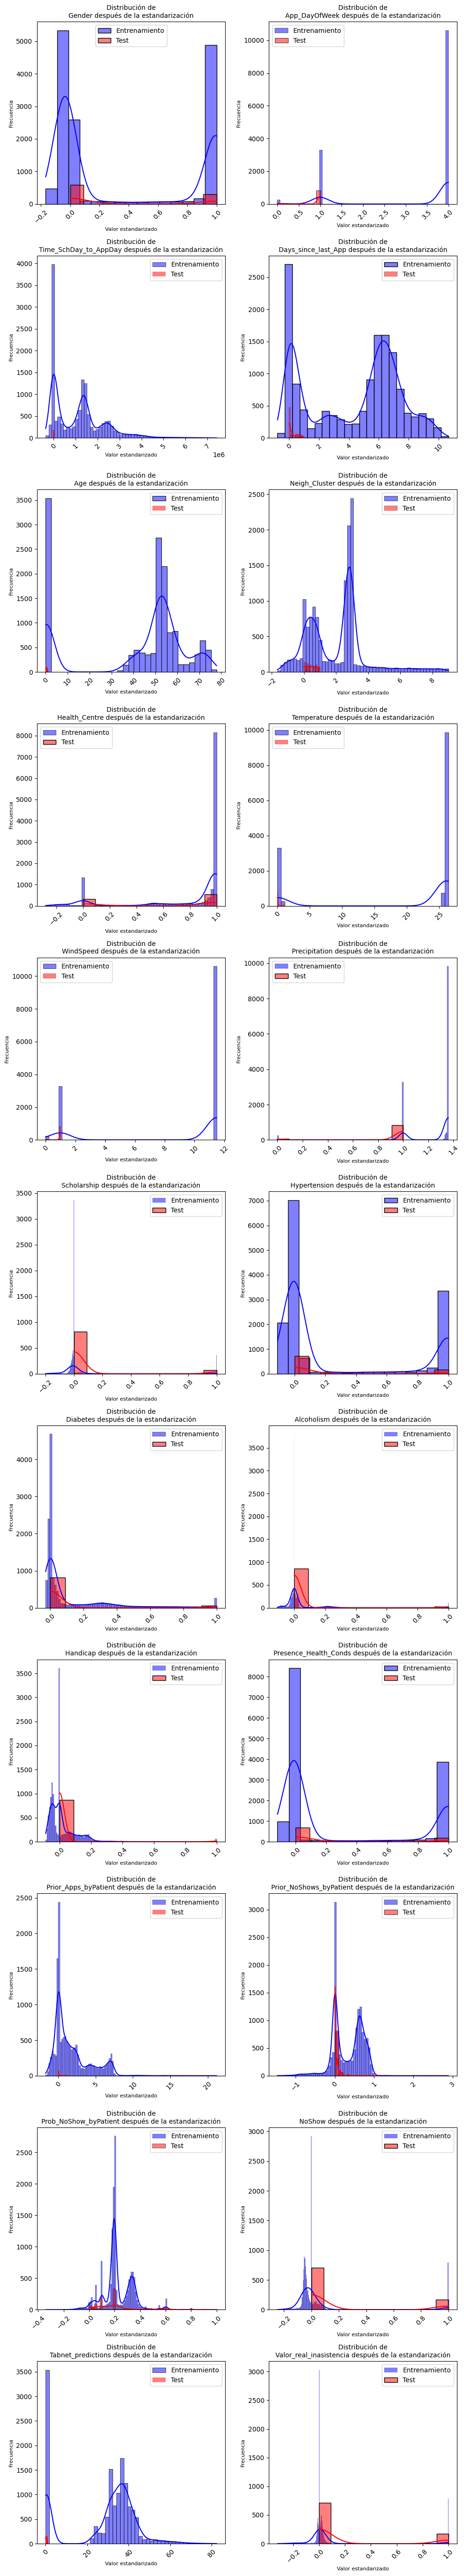

In [14]:
# Guardar los nombres de las columnas
column_names = X_train_set.columns

# Convertir los resultados a DataFrame para facilitar la manipulación y visualización,
# utilizando los nombres de las columnas guardados previamente
X_train_df = pd.DataFrame(X_train_set, columns = column_names)
X_test_df = pd.DataFrame(X_test_set, columns = column_names)

# Número de características en el DataFrame
num_features = X_train_df.shape[1]

# Número de columnas para los sub-gráficos
num_columns = 2

# Calcular el número de filas basado en el número de características y columnas
num_rows = num_features // num_columns + (num_features % num_columns > 0)


# Crear una figura grande para acomodar todos los sub-gráficos
plt.figure(figsize=(10, 5 * num_rows))

# Crear un histograma para cada característica
for i in range(num_features):
    plt.subplot(num_rows, num_columns, i+1)

    # Histograma de los datos de entrenamiento en azul
    sns.histplot(X_train_df.iloc[:, i], kde=True, color='blue', alpha=0.5, label='Entrenamiento')

    # Histograma de los datos de test en rojo
    sns.histplot(X_test_df.iloc[:, i], kde=True, color='red', alpha=0.5, label='Test')

    # Usar un salto de línea para dividir el título en dos líneas
    plt.title(f'Distribución de\n{column_names[i]} después de la estandarización', fontsize=10)

    plt.xlabel('Valor estandarizado', fontsize=8)
    plt.ylabel('Frecuencia', fontsize=8)
    plt.xticks(rotation=45)
    plt.legend()

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

In [15]:
# Se define la funcion para graficar la perdida por epoca para red neuronal de pytorch
def graficar_progreso(losses, inicio_folds, dataset_name, grado=3):
    plt.figure(figsize=(20, 10))
    # Gráfico original
    plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='blue', label='Pérdida Real')

     # Marcar y anotar el inicio de cada fold
    for i, inicio in enumerate(inicio_folds):
        plt.axvline(x=inicio, color='black', linestyle='--', lw=1)
        plt.text(inicio, max(losses)*0.95, f'Inicio Fold {i+1}', rotation=90, color='black', fontsize=12, fontweight='bold')

    # Ajustando la curva de tendencia
    z = np.polyfit(range(1, len(losses) + 1), losses, grado)  # Ajuste polinomial
    p = np.poly1d(z)  # Creación de un polinomio
    plt.plot(range(1, len(losses) + 1), p(range(1, len(losses) + 1)), "r--", label='Curva de Tendencia')  # Curva de tendencia en rojo

    # Configuración del gráfico
    plt.title(f'Pérdida por Época a través de los Folds, Dataset: {dataset_name}')
    plt.xlabel('Época Total')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
def evaluar_modelo_tabnet(model, X_train, y_train, X_test, y_test, dataset_name):
    # Evaluación con datos de entrenamiento
    y_pred_train = model.predict(X_train)

    # Cálculo de métricas para datos de entrenamiento
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    # Visualización de métricas para datos de entrenamiento
    print('\033[1m' + '.' * len("Resultados datos de entrenamiento:") + '\n' + "Resultados datos de entrenamiento:" + '\033[0m')
    print(f"MSE (Datos de Train): {mse_train}")
    print(f"MAE (Datos de Train): {mae_train}")
    print(f"R2 Score (Datos de Train): {r2_train}")

    # Gráfico de comparación entre valores reales y predichos en el conjunto de entrenamiento
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train, y_pred_train, alpha=0.3, color='blue')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    plt.xlabel('Valores Reales (Train)')
    plt.ylabel('Valores Predichos (Train)')
    plt.title(f'Comparación Valores Reales vs. Predichos (Train) - {dataset_name}')
    plt.show()

    # Evaluación con datos de prueba
    y_pred_test = model.predict(X_test)

    # Cálculo de métricas para datos de prueba
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    # Visualización de métricas para datos de prueba
    print('\033[1m' + '.' * len("Resultados datos de test:") + '\n' + "Resultados datos de test:" + '\033[0m')
    print(f"MSE (Datos de Test): {mse_test}")
    print(f"MAE (Datos de Test): {mae_test}")
    print(f"R2 Score (Datos de Test): {r2_test}")

    # Gráfico de comparación entre valores reales y predichos en el conjunto de prueba
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.3, color='red')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Valores Reales (Test)')
    plt.ylabel('Valores Predichos (Test)')
    plt.title(f'Comparación Valores Reales vs. Predichos (Test) - {dataset_name}')
    plt.show()

In [17]:
def execute_model_tabnet(X_train, y_train, X_test, y_test, device, dataset_name, num_epochs=300, patience=15):
    # Convertir datos a NumPy (no a tensores de PyTorch para TabNet)
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.to_numpy()
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_numpy().reshape(-1, 1)
    if isinstance(y_test, pd.Series):
        y_test = y_test.to_numpy().reshape(-1, 1)

    # Parámetros del modelo TabNet ajustados
    model_params = dict(
        n_d=64,  # Dimensiones reducidas
        n_a=64,  # Mantener coherencia entre capas de decisión y atención
        n_steps=5,  # Reducir el número de pasos para evitar sobreajuste
        gamma=1.3,  # Controlar la importancia de la elección de características
        n_independent=2, n_shared=2,  # Dividir el aprendizaje entre independiente y compartido
        lambda_sparse=1e-2,  # Regularización aumentada
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=1e-4),  # Reducir la tasa de aprendizaje
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        scheduler_params=dict(mode="min", patience=10, verbose=True),  # Ajuste del scheduler
        mask_type='entmax',  # Alternativa a softmax para mejorar la estabilidad
        device_name=device
    )

    model_dir = 'models'
    os.makedirs(model_dir, exist_ok=True)
    model_filename = os.path.join(model_dir, f'modelo_tabnet_{dataset_name}.pkl')

    # Cargar modelo si existe
    if os.path.exists(model_filename):
        try:
            model = joblib.load(model_filename)
            print("Modelo cargado exitosamente.")
            print("Resultados del entrenamiento:")
            print(model.history)
            evaluar_modelo_tabnet(model, X_train, y_train, X_test, y_test, dataset_name)
            return
        except Exception as e:
            print(f"Error al cargar el modelo: {e}. Procediendo con el entrenamiento.")

    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

    losses = []  # Lista para registrar las pérdidas a lo largo de las épocas
    inicio_folds = [0]  # Lista para marcar los inicios de los folds

    best_global_val_loss = float('inf')
    best_model = None

    # Entrenamiento con validación cruzada
    for fold, (train_index, valid_index) in enumerate(kfolds.split(X_train, y_train), 1):
        print(f'Comenzando el fold {fold}')

        # Separar los datos del fold
        X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

        try:
            # Inicializar TabNet para cada fold
            model = TabNetRegressor(**model_params)

            # Entrenar el modelo
            model.fit(
                X_train=X_train_fold, y_train=y_train_fold,
                eval_set=[(X_valid_fold, y_valid_fold)],
                eval_name=['valid'],
                eval_metric=['rmse'],
                max_epochs=num_epochs, patience=patience,
                batch_size=128, virtual_batch_size=64
            )

            # Registrar las pérdidas
            losses.extend(model.history['loss'])
            inicio_folds.append(len(losses))  # Marcar el final de cada fold

            # Guardar el mejor modelo
            best_fold_loss = min(model.history['valid_rmse'])
            if best_fold_loss < best_global_val_loss:
                best_global_val_loss = best_fold_loss
                best_model = model

        except Exception as e:
            print(f"Error en el fold {fold}: {e}")

    # Guardar el mejor modelo
    if best_model is not None:
        joblib.dump(best_model, model_filename)
        print(f"Mejor modelo guardado en {model_filename}")

        # Graficar el progreso
        graficar_progreso(losses, inicio_folds, dataset_name)

        # Evaluar el modelo final
        evaluar_modelo_tabnet(best_model, X_train, y_train, X_test, y_test, dataset_name)
    else:
        print("No se pudo entrenar ningún modelo exitosamente.")

# Función para graficar la pérdida por épocas
def graficar_progreso(losses, inicio_folds, dataset_name, grado=3):
    plt.figure(figsize=(20, 10))
    # Gráfico original
    plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='blue', label='Pérdida Real')

     # Marcar y anotar el inicio de cada fold
    for i, inicio in enumerate(inicio_folds):
        plt.axvline(x=inicio, color='black', linestyle='--', lw=1)
        plt.text(inicio, max(losses)*0.95, f'Inicio Fold {i+1}', rotation=90, color='black', fontsize=12, fontweight='bold')

    # Ajustando la curva de tendencia
    z = np.polyfit(range(1, len(losses) + 1), losses, grado)  # Ajuste polinomial
    p = np.poly1d(z)  # Creación de un polinomio
    plt.plot(range(1, len(losses) + 1), p(range(1, len(losses) + 1)), "r--", label='Curva de Tendencia')  # Curva de tendencia en rojo

    # Configuración del gráfico
    plt.title(f'Pérdida por Época a través de los Folds, Dataset: {dataset_name}')
    plt.xlabel('Época Total')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    plt.show()




Comenzando el fold 1
epoch 0  | loss: 6.18907 | valid_rmse: 1.518720030784607|  0:00:03s
epoch 1  | loss: 2.65297 | valid_rmse: 0.9289199709892273|  0:00:07s
epoch 2  | loss: 1.66103 | valid_rmse: 0.8528199791908264|  0:00:11s
epoch 3  | loss: 1.35945 | valid_rmse: 0.7326400279998779|  0:00:15s
epoch 4  | loss: 1.19408 | valid_rmse: 0.9194700121879578|  0:00:18s
epoch 5  | loss: 1.13967 | valid_rmse: 0.8674600124359131|  0:00:22s
epoch 6  | loss: 0.98056 | valid_rmse: 0.8150299787521362|  0:00:26s
epoch 7  | loss: 0.87976 | valid_rmse: 0.7162299752235413|  0:00:29s
epoch 8  | loss: 0.83809 | valid_rmse: 0.8519200086593628|  0:00:33s
epoch 9  | loss: 0.73907 | valid_rmse: 0.6100999712944031|  0:00:37s
epoch 10 | loss: 0.69588 | valid_rmse: 0.5573300123214722|  0:00:41s
epoch 11 | loss: 0.65373 | valid_rmse: 0.5417600274085999|  0:00:44s
epoch 12 | loss: 0.598   | valid_rmse: 0.49720999598503113|  0:00:48s
epoch 13 | loss: 0.53815 | valid_rmse: 0.5078700184822083|  0:00:52s
epoch 14 | lo

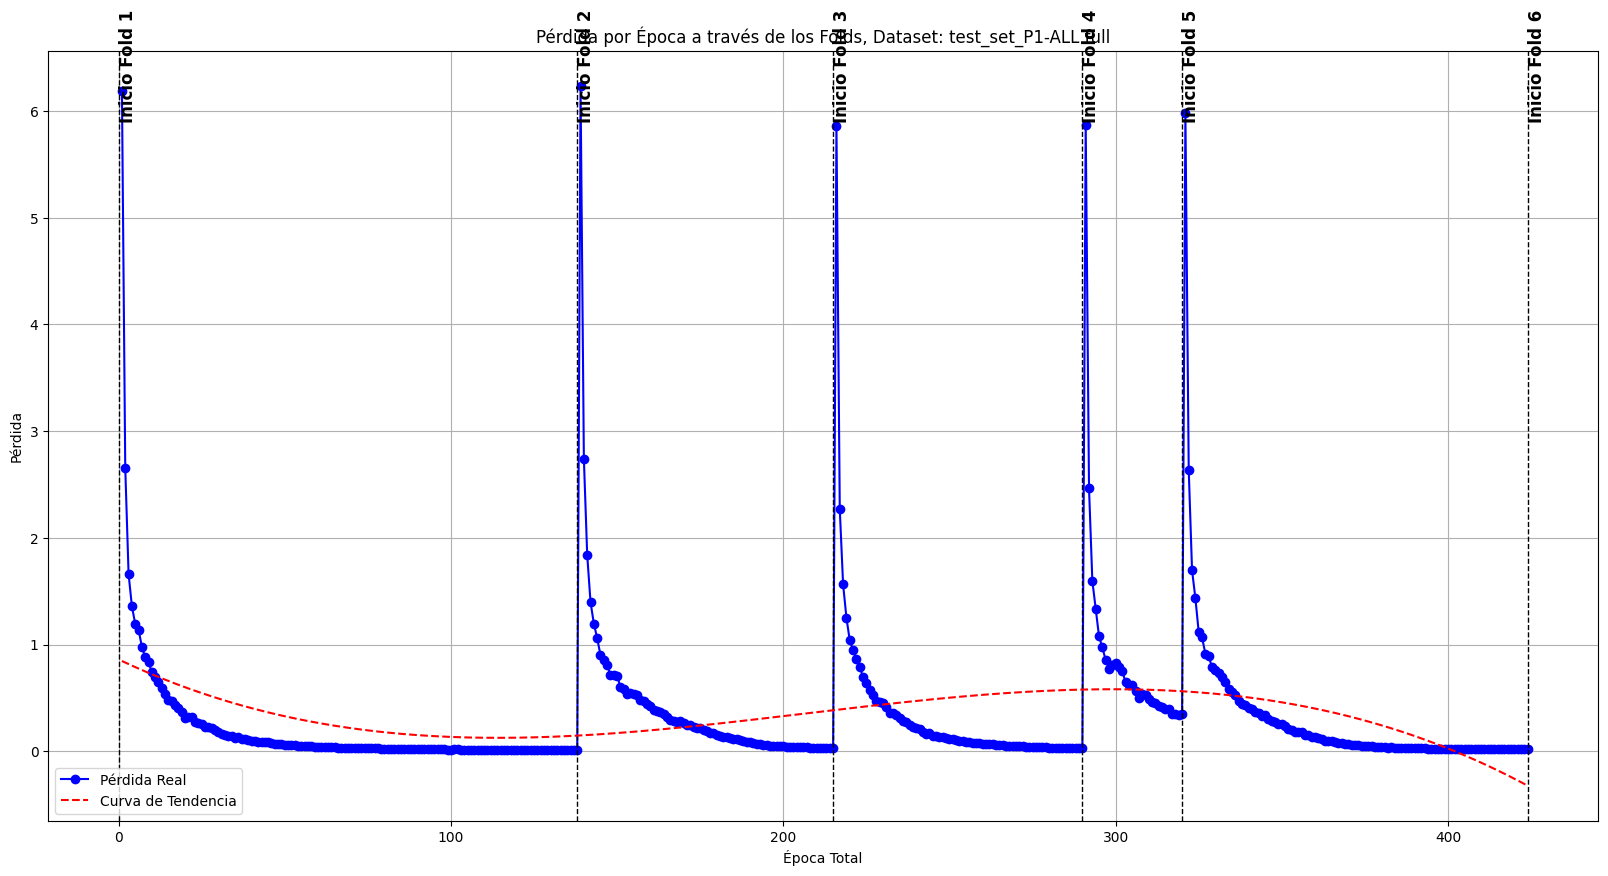

..................................
Resultados datos de entrenamiento:
MSE (Datos de Train): 0.0035207136534154415
MAE (Datos de Train): 0.042338937520980835
R2 Score (Datos de Train): -7.617518424987793


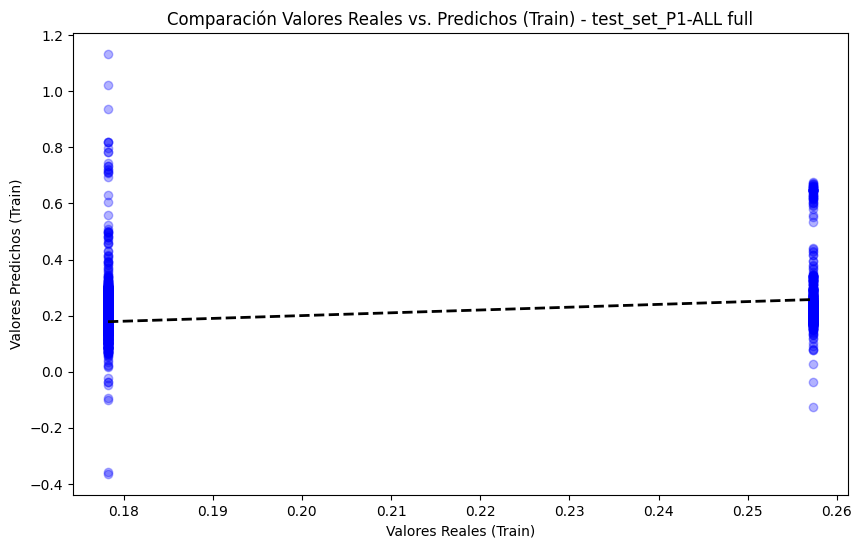

.........................
Resultados datos de test:
MSE (Datos de Test): 0.00469317426905036
MAE (Datos de Test): 0.043524377048015594
R2 Score (Datos de Test): -11.659619331359863


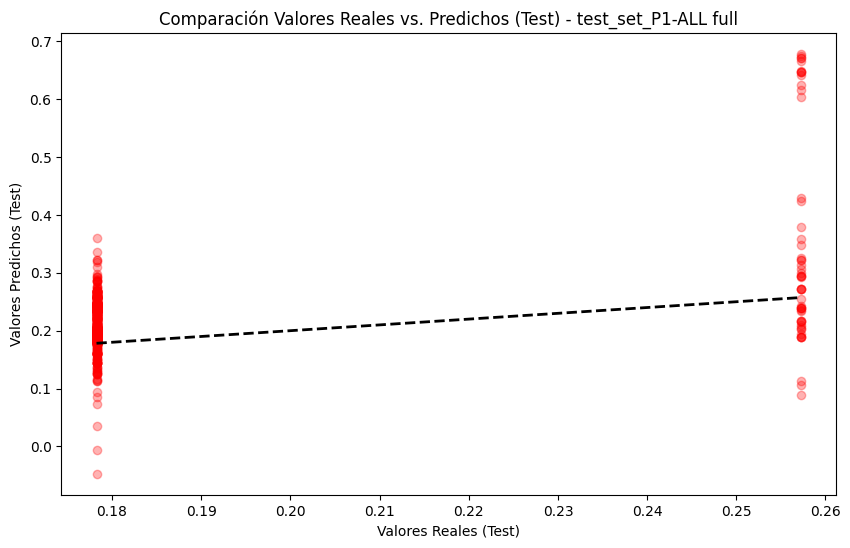

In [18]:
execute_model_tabnet(
    X_train=X_train_set,
    y_train=y_train_set,
    X_test=X_test_set,
    y_test=y_test_set,
    device=device,
    dataset_name="test_set_P1-ALL full",
    num_epochs=300,
    patience=15
)

In [19]:
#Se realiza inferencia con el modelo entrenaddo de una fila  aleatoria del dataset de prueba, y se compara con el valor real
random_index = np.random.randint(0, X_test_set.shape[0])
X_random = X_test_set.iloc[random_index]

# Convertir la fila a un tensor de PyTorch
X_random_tensor = torch.tensor(X_random.values, dtype=torch.float32).reshape(1, -1).to(device)

# Cargar el modelo entrenado
model_dir = 'models'

# Cargar el modelo entrenado
model_filename = os.path.join(model_dir, 'modelo_tabnet_test_set_P1-ALL full.pkl')

# Cargar el modelo entrenado
model = joblib.load(model_filename)

# Realizar la predicción
with torch.no_grad():
    y_pred = model.predict(X_random_tensor)

# Obtener el valor real
y_real = y_test_set[random_index]

# Imprimir los resultados
print(f"Valor Real: {y_real}")
print(f"Predicción: {y_pred[0]}")

Valor Real: [0.17825784]
Predicción: [0.18348944]
